In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import ParameterGrid
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import acf, pacf

In [2]:
stock_price = pd.read_csv("../data/Singtel_stock_data.csv")
stock_price.dropna(inplace = True)

In [3]:
stock_price['Date'] = pd.to_datetime(stock_price['Date'], format='%Y-%m-%d')
stock_price['Adj Close'] = pd.to_numeric(stock_price['Adj Close'], errors='coerce')

In [4]:
stock_price['log_return'] = np.log(stock_price['Adj Close'] / stock_price['Adj Close'].shift(1))
stock_price.dropna(inplace = True)
stock_price.set_index('Date', inplace=True)

In [5]:
# Assuming 'stock_price' is your DataFrame and 'log_return' is the column containing the log returns
fig_log = px.line(stock_price, x=stock_price.index, y='log_return', title='Log Return')
fig_log.update_traces(line=dict(width = 1))
# Show the figure
fig_log.show()

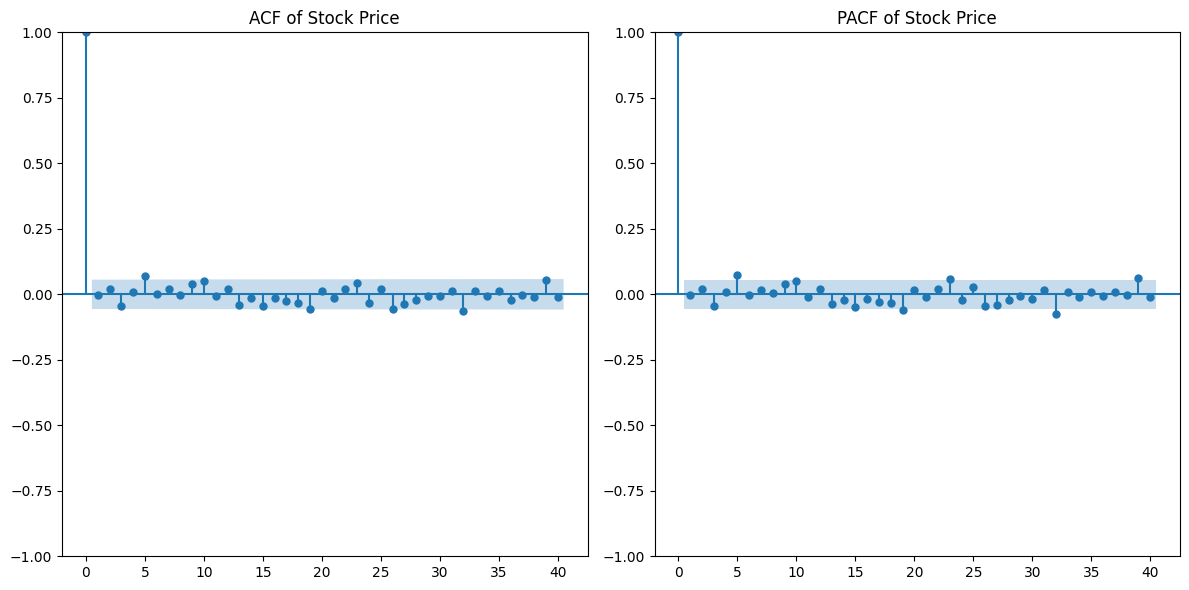

In [6]:
# Draw ACF and PACF plot
plot_data = stock_price['log_return']
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(plot_data, lags=40, ax=plt.gca())
plt.title('ACF of Stock Price')

plt.subplot(122)
plot_pacf(plot_data, lags=40, ax=plt.gca())
plt.title('PACF of Stock Price')

plt.tight_layout()
plt.show()

In [7]:
# Assuming stock_price is your DataFrame and you are plotting the 'Adj Close' column
log_data = stock_price['log_return']

# Compute ACF and PACF values
acf_values = acf(log_data, nlags=40)
pacf_values = pacf(log_data, nlags=40)

# Create ACF plot using plotly.graph_objects
fig_acf = go.Figure()

# ACF Plot
fig_acf.add_trace(go.Scatter(x=np.arange(len(acf_values)), y=acf_values, mode='lines+markers', name='ACF'))
fig_acf.update_layout(title='ACF of Log Return', xaxis_title='Lags', yaxis_title='ACF')

# Show ACF plot
fig_acf.show()

# Create PACF plot using plotly.graph_objects
fig_pacf = go.Figure()

# PACF Plot
fig_pacf.add_trace(go.Scatter(x=np.arange(len(pacf_values)), y=pacf_values, mode='lines+markers', name='PACF'))
fig_pacf.update_layout(title='PACF of Log Return', xaxis_title='Lags', yaxis_title='PACF')

# Show PACF plot
fig_pacf.show()


c:\Users\LJM\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\LJM\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\LJM\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\LJM\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\LJ

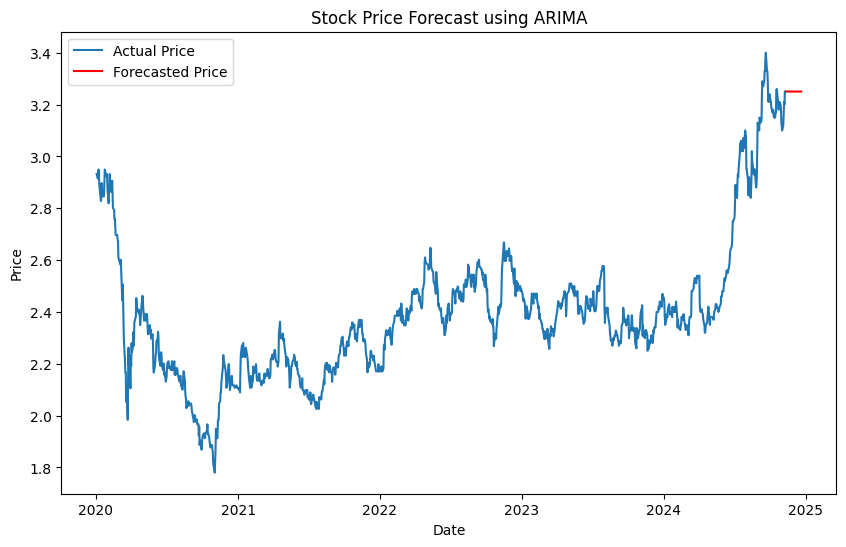

In [8]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# ARIMA model: we use 'Adj Close' for forecasting
model = ARIMA(stock_price['Adj Close'], order=(1, 1, 1))  # ARIMA(p, d, q) model
model_fit = model.fit()

# Forecasting for the next 30 days
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Plotting the actual and forecasted prices
plt.figure(figsize=(10, 6))
plt.plot(stock_price.index, stock_price['Adj Close'], label='Actual Price')
plt.plot(pd.date_range(stock_price.index[-1], periods=forecast_steps+1, freq='B')[1:], forecast, label='Forecasted Price', color='red')
plt.title('Stock Price Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [9]:
# Calculate rolling volatility (standard deviation of log returns)
window = 30  # 30-day rolling window
stock_price['Rolling Volatility'] = stock_price['log_return'].rolling(window=window).std()

fig_volatility = px.line(stock_price, x=stock_price.index, y='Rolling Volatility', 
              title='Rolling Volatility (Risk) Over Time',
              labels={'Date': 'Date', 'Rolling Volatility': 'Volatility'})
fig_volatility.show()

In [12]:
from arch import arch_model

# Build GARCH model
am = arch_model(stock_price['log_return']*100, vol='GARCH', p=1, q=1)
res = am.fit(disp='off')

# Predict the volatility of next 30 days
forecast = res.forecast(horizon=90)

# Extract the variance of the prediction
variance = forecast.variance.values[-1,:]

# Calculation of conditional standard deviation (volatility)
cond_vol = np.sqrt(variance)

# Create date index
forecast_index = pd.date_range(start=stock_price.index[-1], periods=90, freq='D')

# Assuming forecast_index and cond_vol are defined as in the previous context
fig = px.line(x=forecast_index, y=cond_vol, labels={'x': 'Date', 'y': 'Conditional volatility'}, 
              title='The next 90 day volatility predicted by the GARCH model')
fig.show()


In [13]:
# Get Standardized residuals
std_resid = res.resid / res.conditional_volatility

# Plot Standardized residuals
fig = px.line(x=std_resid.index, y=std_resid, labels={'x': 'Date', 'y': 'Standardized Residuals'},
              title='Standardized Residuals')

fig.show()

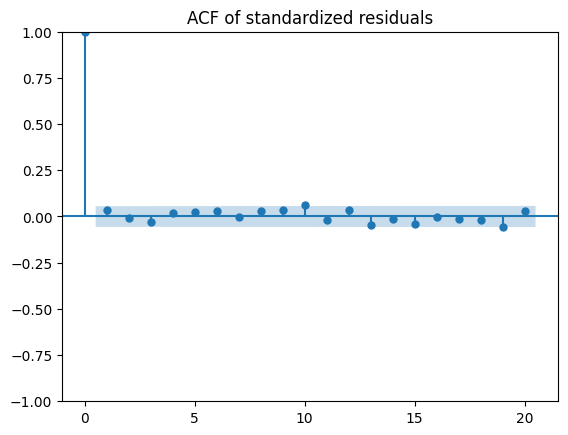

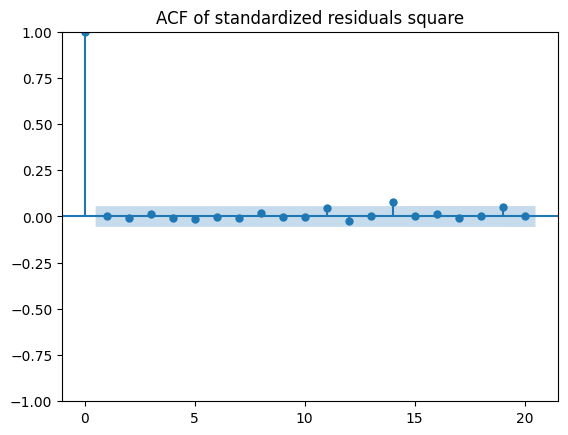

In [ ]:
plot_acf(std_resid, lags=20)
plt.title('ACF of standardized residuals')
plt.show()

plot_acf(std_resid**2, lags=20)
plt.title('ACF of standardized residuals square')
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test of standardized residuals
lb_resid = acorr_ljungbox(std_resid, lags=[10], return_df=True)
print('Ljung-Box test of standardized residuals：')
print(lb_resid)

# Ljung-Box test of standardized residuals square
lb_resid2 = acorr_ljungbox(std_resid**2, lags=[10], return_df=True)
print('Ljung-Box test of standardized residuals square：')
print(lb_resid2)


Ljung-Box test of standardized residuals：
      lb_stat  lb_pvalue
10  12.352295    0.26217
Ljung-Box test of standardized residuals square：
     lb_stat  lb_pvalue
10  1.181443   0.999632


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Standardize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_price['log_return'].values.reshape(-1,1))

# Create training and test data sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create a data set function
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60  # Use the data from last 60 day to predict
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Training model
model.fit(X_train, Y_train, epochs=20, batch_size=64, verbose=1)

# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform data to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])



Epoch 1/20


c:\Users\LJM\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0588
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0115
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0077
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0072
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0074
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0074
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0080
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0069
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0071
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0076
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0072
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0071
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0079
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0073
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0071
Epoch 16/20
15/

In [ ]:

# Visualization
fig = px.line(x=stock_price.index[look_back:train_size], y=Y_train[0], 
              labels={'x': 'Date', 'y': 'Stock Price'}, 
              title='Stock Price Real vs Predicted for Training and Testing')

# Adding the predicted and actual lines for both training and testing data
fig.add_scatter(x=stock_price.index[look_back:train_size], y=train_predict[:,0], mode='lines', name='Predicted data for training')
fig.add_scatter(x=stock_price.index[train_size+look_back:], y=Y_test[0], mode='lines', name='Real data for testing')
fig.add_scatter(x=stock_price.index[train_size+look_back:], y=test_predict[:,0], mode='lines', name='Predicted data for testing')

fig.show()

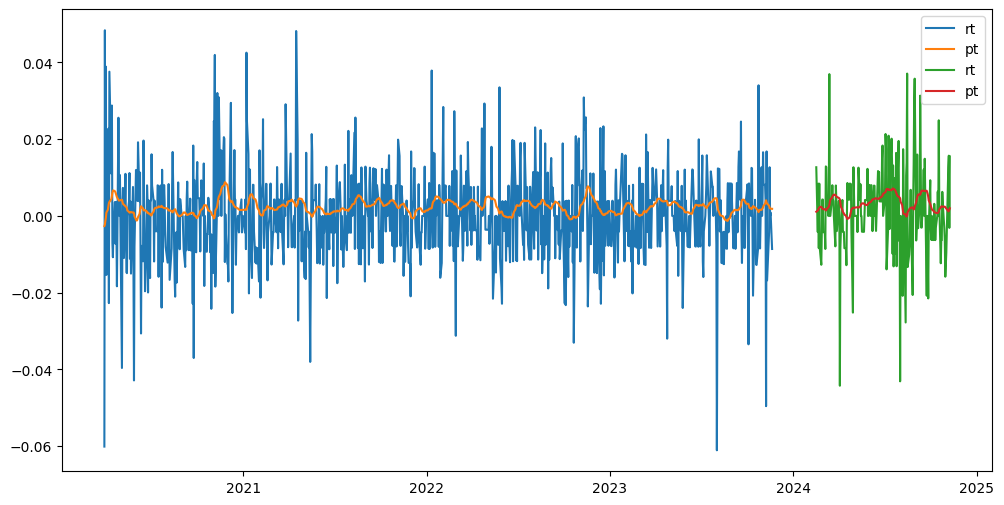

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(stock_price.index[look_back:train_size], Y_train[0], label='rt')
plt.plot(stock_price.index[look_back:train_size], train_predict[:,0], label='pt')
plt.plot(stock_price.index[train_size+look_back:], Y_test[0], label='rt')
plt.plot(stock_price.index[train_size+look_back:], test_predict[:,0], label='pt')
plt.legend()
plt.show()